# Hyperparameter Optimization for Tree Ensemble with Uncertainty Quantification (Scikit-Learn)

In [1]:
import matplotlib.pyplot as plt
WIDTH_PLOTS = 8
HEIGHT_PLOTS = WIDTH_PLOTS / 1.618

## Data

In [2]:
import numpy as np
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split


# Dataset
def flip_binary_labels(y, ratio, random_state=None):
    """Increase the variance of P(Y|X) by ``ratio``"""
    y_flipped = np.zeros(np.shape(y))
    y_flipped[:] = y[:]
    rs = np.random.RandomState(random_state)
    idx = np.arange(len(y_flipped))
    idx = rs.choice(idx, size=int(ratio * len(y_flipped)), replace=False)
    y_flipped[idx] = 1 - y_flipped[idx]
    return y_flipped


def load_data_train_test(random_state=42):
    noise = 0.1
    n = 1_000
    ratio_flipped = 0.1

    rng = np.random.RandomState(random_state)

    # Moons
    make_dataset = lambda n, seed: make_moons(
        n_samples=n,
        noise=noise,
        shuffle=True,
        random_state=seed,
    )

    X, y = make_dataset(n, rng.randint(2**31))
    center = np.mean(X, axis=0)
    X = X - center

    y = flip_binary_labels(y, ratio=ratio_flipped, random_state=rng.randint(2**31))
    y = y.astype(np.int64)

    train_X, test_X, train_y, test_y = train_test_split(
        X, y, test_size=0.33, random_state=rng.randint(2**31), stratify=y
    )

    return (train_X, train_y), (test_X, test_y)


def load_data_train_valid(verbose=0, random_state=42):

    (x, y), _ = load_data_train_test(random_state=random_state)

    train_X, valid_X, train_y, valid_y = train_test_split(
        x, y, test_size=0.33, random_state=random_state, stratify=y
    )

    if verbose:
        print(f"train_X shape: {np.shape(train_X)}")
        print(f"train_y shape: {np.shape(train_y)}")
        print(f"valid_X shape: {np.shape(valid_X)}")
        print(f"valid_y shape: {np.shape(valid_y)}")
    return (train_X, train_y), (valid_X, valid_y)

## Training and Scoring of Decision Tree

In [3]:
def plot_decision_boundary_decision_tree(dataset, labels, model, steps=1000, color_map="viridis"):
    color_map = plt.get_cmap(color_map)
    # Define region of interest by data limits
    xmin, xmax = dataset[:, 0].min() - 1, dataset[:, 0].max() + 1
    ymin, ymax = dataset[:, 1].min() - 1, dataset[:, 1].max() + 1
    x_span = np.linspace(xmin, xmax, steps)
    y_span = np.linspace(ymin, ymax, steps)
    xx, yy = np.meshgrid(x_span, y_span)

    # Make predictions across region of interest
    labels_predicted = model.predict_proba(np.c_[xx.ravel(), yy.ravel()])

    # Plot decision boundary in region of interest
    z = labels_predicted[:, 1].reshape(xx.shape)

    ax = plt.gca()
    ax.contourf(xx, yy, z, cmap=color_map, alpha=0.5)

    # Get predicted labels on training data and plot
    ax.scatter(
        dataset[:, 0],
        dataset[:, 1],
        c=labels,
        # cmap=color_map,
        lw=0,
    )
    plt.show()

In [4]:
import pathlib
import pickle
import os

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import log_loss

hpo_dir = "hpo_sklearn_classification"
model_checkpoint_dir = os.path.join(hpo_dir, "models")

def run(job, model_checkpoint_dir=".", verbose=True, show_plots=False):
    if verbose:
        print(f"{job.id}: Start running...")

    (x, y), (vx, vy) = load_data_train_valid(verbose=verbose)
    _, (tx, ty) = load_data_train_test()

    if show_plots:
        plt.figure(figsize=(WIDTH_PLOTS, HEIGHT_PLOTS))

        plt.scatter(
            x[:, 0].reshape(-1), x[:, 1].reshape(-1), c=y, label="train", alpha=0.8
        )
        plt.scatter(
            vx[:, 0].reshape(-1),
            vx[:, 1].reshape(-1),
            c=vy,
            marker="s",
            label="valid",
            alpha=0.8,
        )

        plt.ylabel("$x1$", fontsize=12)
        plt.xlabel("$x0$", fontsize=12)

        plt.legend(loc="upper center", ncol=3, fontsize=12)

        plt.show()

    model = DecisionTreeClassifier(**job.parameters)

    if verbose:
        print(model)

    try:
        model.fit(x, y)
        vy_pred_proba = model.predict_proba(vx)
        score = log_loss(vy, vy_pred_proba)
    except:
        return "F_fit"

    # Saving the model

    with open(os.path.join(model_checkpoint_dir, f"model_{job.id}.pkl"), "wb") as f:
        pickle.dump(model, f)

    if verbose:
        print(f"{job.id}: CCE: {score}")

    if show_plots:
        plt.figure(figsize=(WIDTH_PLOTS, HEIGHT_PLOTS))

        plot_decision_boundary_decision_tree(
            tx, ty, model, steps=1000, color_map="viridis"
        )

    # The score is negated for maximization
    # The score is -Categorical Cross Entropy/LogLoss
    return {"objective": -score}

## Hyperparameter Optimization Search Space

In [5]:
from deephyper.hpo import HpProblem


def create_hpo_problem():

    problem = HpProblem()

    problem.add_hyperparameter(["gini", "entropy", "log_loss"], "criterion")
    problem.add_hyperparameter(["best", "random"], "splitter")
    problem.add_hyperparameter((10, 1000, "log-uniform"), "max_depth", default_value=1000)
    problem.add_hyperparameter((2, 20), "min_samples_split", default_value=2)
    problem.add_hyperparameter((1, 20), "min_samples_leaf", default_value=1)
    problem.add_hyperparameter((0.0, 0.5), "min_weight_fraction_leaf", default_value=0.0)

    return problem

## The Baseline Decision Tree

In [6]:
from deephyper.evaluator import RunningJob


def evaluate_decision_tree():

    model_checkpoint_dir = "models_sklearn_test"
    pathlib.Path(model_checkpoint_dir).mkdir(parents=True, exist_ok=True)

    problem = create_hpo_problem()
    print(problem)

    default_parameters = problem.default_configuration
    print(f"{default_parameters=}")
    output = run(
        RunningJob(id="test", parameters=default_parameters),
        model_checkpoint_dir=model_checkpoint_dir,
        show_plots=True,
    )
    print(f"{output=}")

Configuration space object:
  Hyperparameters:
    criterion, Type: Categorical, Choices: {gini, entropy, log_loss}, Default: gini
    max_depth, Type: UniformInteger, Range: [10, 1000], Default: 1000, on log-scale
    min_samples_leaf, Type: UniformInteger, Range: [1, 20], Default: 1
    min_samples_split, Type: UniformInteger, Range: [2, 20], Default: 2
    min_weight_fraction_leaf, Type: UniformFloat, Range: [0.0, 0.5], Default: 0.0
    splitter, Type: Categorical, Choices: {best, random}, Default: best

default_parameters={'criterion': 'gini', 'max_depth': 1000, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'splitter': 'best'}
0.0: Start running...
train_X shape: (448, 2)
train_y shape: (448,)
valid_X shape: (222, 2)
valid_y shape: (222,)


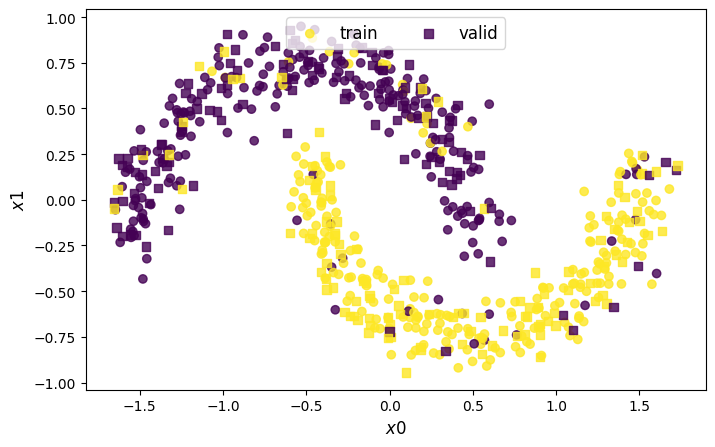

DecisionTreeClassifier(max_depth=1000)
0.0: CCE: 6.4943519620030905


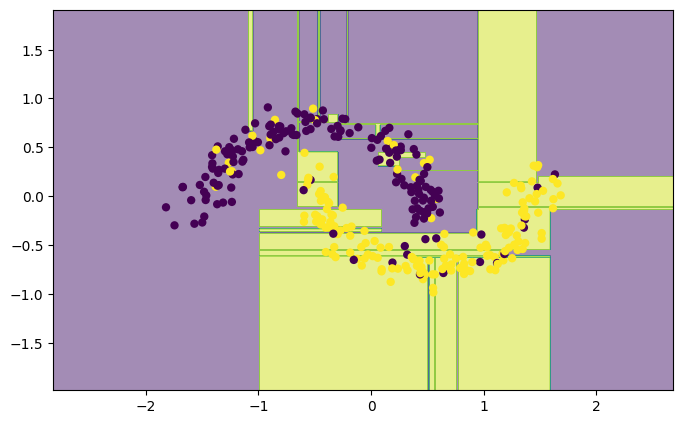

output={'objective': -6.4943519620030905}


In [7]:
evaluate_decision_tree()

## Hyperparameter Optimization

In [8]:
from deephyper.hpo import CBO
from deephyper.evaluator import Evaluator
from deephyper.evaluator.callback import TqdmCallback


def run_hpo():

    pathlib.Path(model_checkpoint_dir).mkdir(parents=True, exist_ok=True)

    problem = create_hpo_problem()

    evaluator = Evaluator.create(
        run,
        method="ray",
        method_kwargs={
            "num_cpus": 8,
            "num_cpus_per_task": 1,
            "run_function_kwargs": {
                "model_checkpoint_dir": model_checkpoint_dir,
                "verbose": False,
            },
            "callbacks": [TqdmCallback()]
        },
    )
    search = CBO(
        problem,
        evaluator,
        log_dir=hpo_dir,
        initial_points=[problem.default_configuration],
        acq_optimizer="mixedga",
        acq_optimizer_freq=1,
        kappa=5.0,
        scheduler={"type": "periodic-exp-decay", "period": 50, "kappa_final": 0.0001},
        objective_scaler="identity",
    )

    results = search.search(max_evals=1_000)

    return results

In [11]:
results = run_hpo()

2024-09-09 10:01:54,151	INFO worker.py:1788 -- Started a local Ray instance.
/Users/romainegele/Documents/Argonne/deephyper/deephyper/evaluator/_evaluator.py:132: UserWarning: Applying nest-asyncio patch for IPython Shell!
  warnings.warn(


  0%|          | 0/1000 [00:00<?, ?it/s]

(run pid=47739) 0.7: CCE: 0.48712541673892923
(run pid=47739) 0.26: CCE: 0.49368215509115687 [repeated 25x across cluster] (Ray deduplicates logs by default. Set RAY_DEDUP_LOGS=0 to disable log deduplication, or see https://docs.ray.io/en/master/ray-observability/user-guides/configure-logging.html#log-deduplication for more options.)
(run pid=47739) 0.41: CCE: 0.47768248618472947 [repeated 16x across cluster]
(run pid=47739) 0.58: CCE: 0.477978111382381 [repeated 16x across cluster]
(run pid=47742) 0.72: CCE: 0.5118454884561905 [repeated 15x across cluster]
(run pid=47739) 0.84: CCE: 0.47768248618472947 [repeated 9x across cluster]
(run pid=47739) 0.100: CCE: 0.47768248618472947 [repeated 16x across cluster]
(run pid=47739) 0.115: CCE: 6.8190695601032445 [repeated 16x across cluster]
(run pid=47739) 0.132: CCE: 0.47768248618472947 [repeated 16x across cluster]
(run pid=47739) 0.146: CCE: 0.47768248618472947 [repeated 16x across cluster]
(run pid=47739) 0.161: CCE: 1.4198267721317468 [r

(run pid=47739) 0.1006: CCE: 0.4714384202872168


In [12]:
results

,p:criterion,p:max_depth,p:min_samples_leaf,p:min_samples_split,p:min_weight_fraction_leaf,p:splitter,objective,job_id,m:timestamp_submit,m:timestamp_gather
0,gini,802,16,17,0.403169,best,-0.511322,6,1.277699,2.687768
1,gini,1000,1,2,0.000000,best,-5.844917,0,1.271685,2.732824
2,gini,857,3,18,0.345690,best,-0.511322,5,1.276858,2.734969
3,log_loss,10,6,6,0.206576,random,-0.693107,2,1.273804,2.737083
4,log_loss,82,17,4,0.250115,random,-0.693107,4,1.276034,2.739724
...,...,...,...,...,...,...,...,...,...,...
995,entropy,108,11,14,0.268454,best,-0.471438,996,657.356421,657.776003
996,entropy,143,11,14,0.268566,best,-0.471438,995,657.355502,657.778192
997,entropy,126,11,14,0.269037,best,-0.471438,999,657.359174,657.780086
998,entropy,128,11,14,0.268317,best,-0.471438,997,657.357514,657.781948


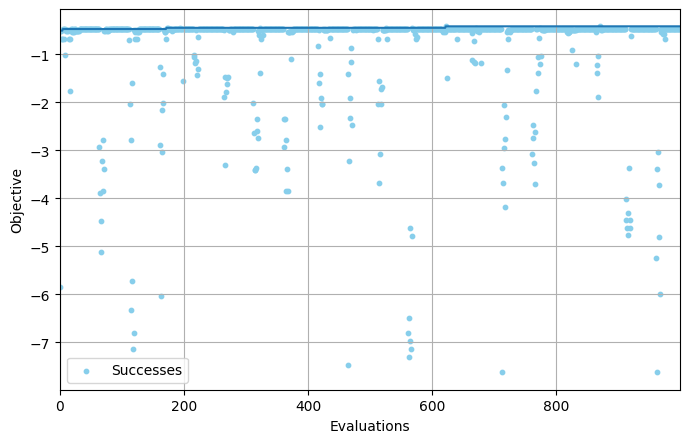

In [13]:
from deephyper.analysis.hpo import plot_search_trajectory_single_objective_hpo

plt.figure(figsize=(WIDTH_PLOTS, HEIGHT_PLOTS))
plot_search_trajectory_single_objective_hpo(results)
plt.show()

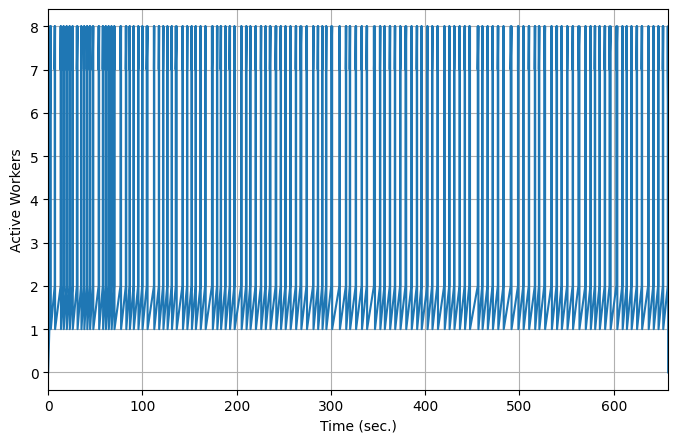

In [14]:
from deephyper.analysis.hpo import plot_worker_utilization

plt.figure(figsize=(WIDTH_PLOTS, HEIGHT_PLOTS))
plot_worker_utilization(results)
plt.show()

## The Best Decision Tree

In [15]:
from deephyper.analysis.hpo import parameters_from_row

topk_rows = results.nlargest(5, "objective").reset_index(drop=True)

for i, row in topk_rows.iterrows():
    parameters = parameters_from_row(row)
    value = row["objective"]
    print(f"Top-{i+1} -> {value=:.3f}: {parameters}")
    print()

Top-1 -> value=-0.421: {'criterion': 'log_loss', 'max_depth': 12, 'min_samples_leaf': 2, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0295131732575053, 'splitter': 'random'}

Top-2 -> value=-0.422: {'criterion': 'log_loss', 'max_depth': 81, 'min_samples_leaf': 3, 'min_samples_split': 3, 'min_weight_fraction_leaf': 0.0703808608299938, 'splitter': 'random'}

Top-3 -> value=-0.453: {'criterion': 'gini', 'max_depth': 279, 'min_samples_leaf': 3, 'min_samples_split': 4, 'min_weight_fraction_leaf': 0.1017852779960649, 'splitter': 'random'}

Top-4 -> value=-0.454: {'criterion': 'gini', 'max_depth': 398, 'min_samples_leaf': 5, 'min_samples_split': 3, 'min_weight_fraction_leaf': 0.0949291617116258, 'splitter': 'random'}

Top-5 -> value=-0.455: {'criterion': 'gini', 'max_depth': 856, 'min_samples_leaf': 1, 'min_samples_split': 7, 'min_weight_fraction_leaf': 0.0769180900605169, 'splitter': 'random'}



In [16]:
best_job = topk_rows.iloc[0]

hpo_dir = "hpo_sklearn_classification"
model_checkpoint_dir = os.path.join(hpo_dir, "models")

with open(os.path.join(model_checkpoint_dir, f"model_0.{best_job.job_id}.pkl"), "rb") as f:
    best_model = pickle.load(f)

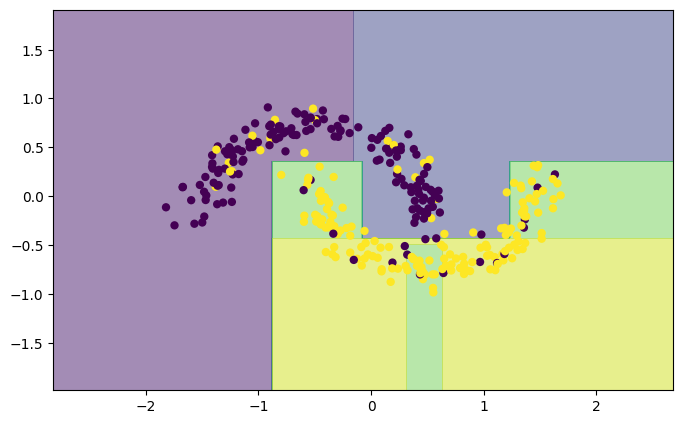

In [17]:
_, (tx, ty) = load_data_train_test()

plt.figure(figsize=(WIDTH_PLOTS, HEIGHT_PLOTS))

plot_decision_boundary_decision_tree(
    tx, ty, best_model, steps=1000, color_map="viridis"
)

## Ensemble of Decision Trees

In [9]:
from deephyper.ensemble import EnsemblePredictor
from deephyper.ensemble.aggregator import MixedCategoricalAggregator
from deephyper.ensemble.loss import CategoricalCrossEntropy 
from deephyper.ensemble.selector import GreedySelector, TopKSelector
from deephyper.predictor.sklearn import SklearnPredictorFileLoader

In [10]:
def plot_decision_boundary_and_uncertainty(
    dataset, labels, model, steps=1000, color_map="viridis", s=5
):

    fig, axs = plt.subplots(
        3, sharex="all", sharey="all", figsize=(WIDTH_PLOTS, HEIGHT_PLOTS * 2)
    )

    # Define region of interest by data limits
    xmin, xmax = dataset[:, 0].min() - 1, dataset[:, 0].max() + 1
    ymin, ymax = dataset[:, 1].min() - 1, dataset[:, 1].max() + 1
    x_span = np.linspace(xmin, xmax, steps)
    y_span = np.linspace(ymin, ymax, steps)
    xx, yy = np.meshgrid(x_span, y_span)

    # Make predictions across region of interest
    y_pred = model.predict(np.c_[xx.ravel(), yy.ravel()].astype(np.float32))
    y_pred_proba = y_pred["loc"]
    y_pred_aleatoric = y_pred["uncertainty_aleatoric"]
    y_pred_epistemic = y_pred["uncertainty_epistemic"]

    # Plot decision boundary in region of interest

    # 1. MODE
    color_map = plt.get_cmap("viridis")
    z = y_pred_proba[:, 1].reshape(xx.shape)

    cont = axs[0].contourf(xx, yy, z, cmap=color_map, vmin=0, vmax=1, alpha=0.5)

    # Get predicted labels on training data and plot
    axs[0].scatter(
        dataset[:, 0],
        dataset[:, 1],
        c=labels,
        cmap=color_map,
        s=s,
        lw=0,
    )
    plt.colorbar(cont, ax=axs[0], label="Probability of class 1")

    # 2. ALEATORIC
    color_map = plt.get_cmap("plasma")
    z = y_pred_aleatoric.reshape(xx.shape)

    cont = axs[1].contourf(xx, yy, z, cmap=color_map, vmin=0, vmax=0.69, alpha=0.5)

    # Get predicted labels on training data and plot
    axs[1].scatter(
        dataset[:, 0],
        dataset[:, 1],
        c=labels,
        cmap=color_map,
        s=s,
        lw=0,
    )
    plt.colorbar(cont, ax=axs[1], label="Aleatoric uncertainty")

    # 3. EPISTEMIC
    z = y_pred_epistemic.reshape(xx.shape)

    cont = axs[2].contourf(xx, yy, z, cmap=color_map, vmin=0, vmax=0.69, alpha=0.5)

    # Get predicted labels on training data and plot
    axs[2].scatter(
        dataset[:, 0],
        dataset[:, 1],
        c=labels,
        cmap=color_map,
        s=s,
        lw=0,
    )
    plt.colorbar(cont, ax=axs[2], label="Epistemic uncertainty")

    plt.show()

In [33]:
def create_ensemble_from_checkpoints(ensemble_selector: str = "topk"):

    # 0. Load data
    _, (vx, vy) = load_data_train_valid(verbose=0)

    # !1.3 SKLEARN EXAMPLE
    predictor_files = SklearnPredictorFileLoader.find_predictor_files(
        model_checkpoint_dir
    )
    predictor_loaders = [SklearnPredictorFileLoader(f) for f in predictor_files]
    predictors = [p.load() for p in predictor_loaders]

    # 2. Build an ensemble
    ensemble = EnsemblePredictor(
        predictors=predictors,
        aggregator=MixedCategoricalAggregator(
            uncertainty_method="entropy", decomposed_uncertainty=True
        ),
        # ! You can specify parallel backends for the evaluation of the ensemble
        evaluator={
            "method": "process",
            "method_kwargs": {"num_workers": 10},
        },
    )
    y_predictors = ensemble.predictions_from_predictors(
        vx, predictors=ensemble.predictors
    )

    # Use TopK or Greedy/Caruana
    if ensemble_selector == "topk":
        selector = TopKSelector(
            loss_func=CategoricalCrossEntropy(),
            k=20,
        )
    elif ensemble_selector == "greedy":
        selector = GreedySelector(
            loss_func=CategoricalCrossEntropy(),
            aggregator=MixedCategoricalAggregator(),
            k=20,
            k_init=5,
            eps_tol=1e-5,
        )
    else:
        raise ValueError(f"Unknown ensemble_selector: {ensemble_selector}")

    selected_predictors_indexes, selected_predictors_weights = selector.select(
        vy, y_predictors
    )
    print(f"{selected_predictors_indexes=}")
    print(f"{selected_predictors_weights=}")

    ensemble.predictors = [ensemble.predictors[i] for i in selected_predictors_indexes]
    ensemble.weights = selected_predictors_weights

    return ensemble

In [34]:
ensemble = create_ensemble_from_checkpoints("topk")

selected_predictors_indexes=[300, 145, 826, 364, 407, 716, 121, 770, 496, 925, 227, 225, 836, 31, 1000, 705, 797, 151, 510, 507]
selected_predictors_weights=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0]


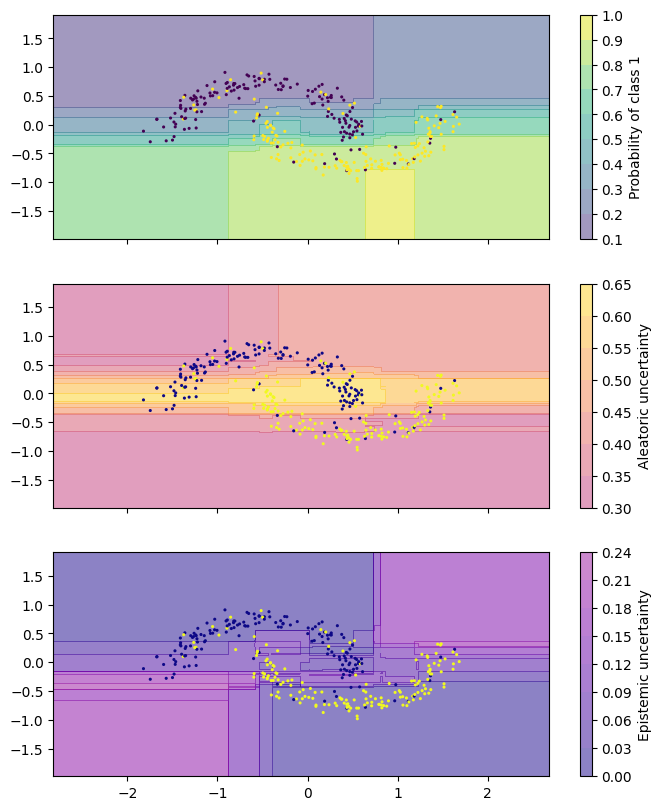

CCE: 0.46820605908631147


In [35]:
plot_decision_boundary_and_uncertainty(tx, ty, ensemble, steps=1000, color_map="viridis")

ty_pred = ensemble.predict(tx)["loc"]

cce = log_loss(ty, ty_pred)

print(f"CCE: {cce}")

In [36]:
ensemble = create_ensemble_from_checkpoints("greedy")

selected_predictors_indexes=[37, 129, 145, 259, 300, 364, 407, 495, 561, 673, 702, 826, 915, 933, 967]
selected_predictors_weights=[0.04225352112676056, 0.04225352112676056, 0.014084507042253521, 0.2535211267605634, 0.014084507042253521, 0.014084507042253521, 0.014084507042253521, 0.04225352112676056, 0.056338028169014086, 0.014084507042253521, 0.04225352112676056, 0.014084507042253521, 0.23943661971830985, 0.014084507042253521, 0.18309859154929578]


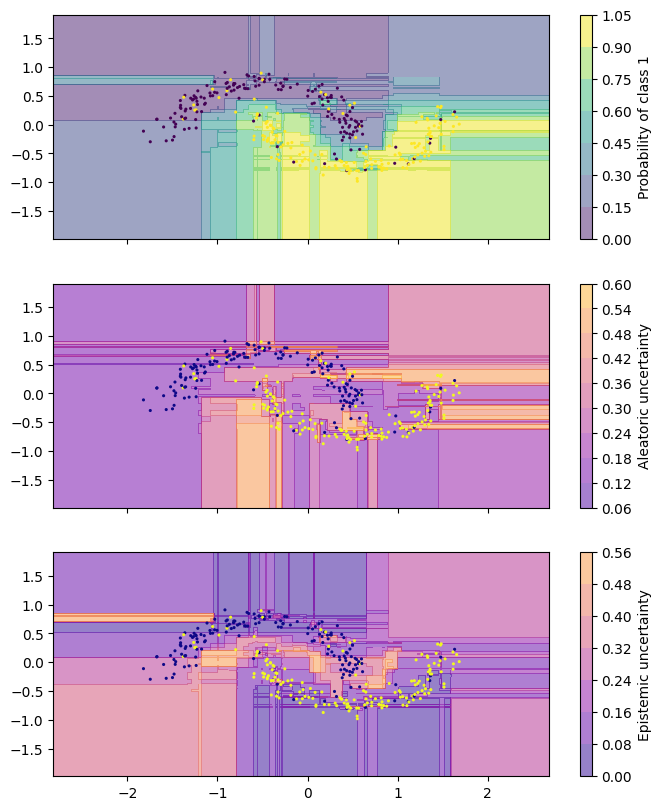

CCE: 0.37694604016436484


In [37]:
plot_decision_boundary_and_uncertainty(tx, ty, ensemble, steps=1000, color_map="viridis")

ty_pred = ensemble.predict(tx)["loc"]

cce = log_loss(ty, ty_pred)

print(f"CCE: {cce}")